# Description

In this notebook, I will train the FL with the Inception Architecture on the FEMNIST dataset.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.random.set_seed(42)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:  tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e: print(e)

import gc
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

from sklearn.model_selection import train_test_split

from config_celeb import *
from utils.read_data_utils import *
from utils.model_utils import *
from utils.pruning_utils import *

2024-06-24 17:12:00.486507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 17:12:00.486529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 17:12:00.486560: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
# =========================================================
# Dataset Hyper-parameter
DATASET_NAME = 'mnist'  # mnist

IMAGE_DIMENSION = 28
INPUT_SHAPE = (IMAGE_DIMENSION, IMAGE_DIMENSION, 1)

OUPUT_SHAPE = 62 # 


# =========================================================
# Model Hyper-parameter
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']

LIST_NUMBER_FILTERS = [32, 16, 16, 16, 32, 32, 32, 96, 96]
FILTER_SIZE = 5

MODEL_TYPE = "inception" # ['vanilla_conv', 'resnet', 'inception']
PATH_GLOBAL_MODEL = os.path.join("models", "global_model_inception_femnist.h5")


# =========================================================
# Training Hyper-parameter
NUM_ROUNDS = 500
NUM_SELECTED_CLIENT = 10

LOCAL_EPOCHS = 5
LOCAL_BATCH_SIZE = 32

# 1. Dataset

## 1.1. Load dataset

In [3]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=False)

num_clients = len(emnist_train.client_ids)
print(f"Number of clients: {num_clients}")

Number of clients: 3400


## 1.2. Prepare training dataset

In [4]:
list_clients_data = Create_Clients_Data(emnist_train, DATASET_NAME)
print(f"Number of user: {len(list_clients_data)}")

Number of user: 3400


Shape of image: (28, 28, 1)
Max value of X: 1.0
Min value of X: 0.038536667823791504
Client = f0006_12
Label = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


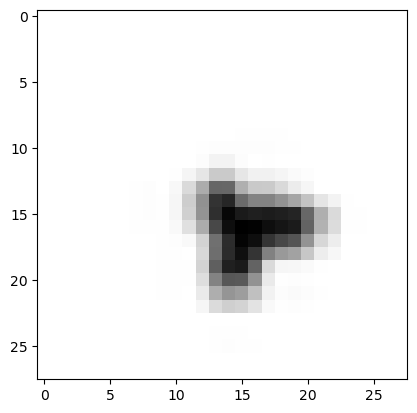

In [5]:
idx_client = np.random.randint(0, 10)
idx_sample = np.random.randint(0, 10)

client_data = list_clients_data[idx_client]

client_name = client_data['client_name']
list_X = client_data['list_X']
list_y = client_data['list_y']

X = list_X[idx_sample]
print(f"Shape of image: {X.shape}")
print(f"Max value of X: {X.max()}")
print(f"Min value of X: {X.min()}")

y = list_y[idx_sample]

print(f"Client = {client_name}")
print(f"Label = {y}")
plt.imshow(X, cmap='gray')
plt.show()

## 1.3. Prepare val - test dataset

In [6]:
list_data_test = Create_Clients_Data(emnist_test)

X_test = []
y_test = []
for data_test in list_data_test:
    X_test.append(data_test['list_X'])
    y_test.append(data_test['list_y'])
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"Shape of X val: {X_val.shape}")
print(f"Shape of y val: {y_val.shape}")

print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X val: (38741, 28, 28, 1)
Shape of y val: (38741, 62)
Shape of X test: (38742, 28, 28, 1)
Shape of y test: (38742, 62)


# 2. FL Training

## 2.1. Define components

In [7]:
def my_inception_module_naive(input_tensor, filters_1x1, filters_3x3, filters_5x5, idx_inception_block):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', name=f"prunable_conv_{1+idx_inception_block*3}")(input_tensor)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', name=f"prunable_conv_{1+idx_inception_block*3+1}")(input_tensor)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', name=f"prunable_conv_{1+idx_inception_block*3+2}")(input_tensor)
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5])
    return output

def define_inception_model(input_shape, output_shape, list_number_filters):
    input_tensor = Input(shape=input_shape)

    X = Conv2D(filters=list_number_filters[0], kernel_size=3, strides=2, activation='relu', name=f'prunable_conv_0')(input_tensor)

    for idx_inception_block in range(1, len(list_number_filters) - 2, 3):
        list_current_filters = list_number_filters[idx_inception_block:idx_inception_block+3]
        filters_1x1, filters_3x3, filters_5x5 = list_current_filters
        X = my_inception_module_naive(X, filters_1x1, filters_3x3, filters_5x5, idx_inception_block-1)

    X = Conv2D(filters=list_number_filters[-2], kernel_size=3, strides=2, activation='relu', name=f'prunable_conv_6')(X)
    X = Conv2D(filters=list_number_filters[-1], kernel_size=3, strides=2, activation='relu', name=f'prunable_conv_7')(X)

    # X = Flatten()(X)
    X = GlobalAveragePooling2D()(X)

    X = Dense(50, activation='relu')(X)
    X = Dense(output_shape, activation='softmax')(X)

    model = tf.keras.Model(inputs=input_tensor, outputs=X)
    return model

In [15]:
keras.backend.clear_session()
global_model = define_inception_model(INPUT_SHAPE, OUPUT_SHAPE, LIST_NUMBER_FILTERS)
global_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
print(f"Number of params: {global_model.count_params()}")

num_conv_layers = Count_Conv2d_Layers(global_model)
print(f"Number of Conv2D layer: {num_conv_layers}")
plot_model(global_model, to_file=os.path.join('images', f'{MODEL_TYPE}.png'), show_shapes=True, show_layer_names=True);
global_model.save(PATH_GLOBAL_MODEL)

flops = get_flops_keras_model(global_model)
print(f"FLOPS of global model: {flops}")

global_model.summary()

Number of params: 246236
Number of Conv2D layer: 9
FLOPS of global model: 31010894
=========================Options=============================

Model: "model"
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are a

## 2.2. FL training

In [9]:
NUM_CLIENTS = num_clients
list_val_acc = []
list_val_loss = []


for idx_round in range(NUM_ROUNDS):
    print("\n [INFO] Round {}".format(idx_round))

    # Load global model at begin of each round.
    global_model = keras.models.load_model(PATH_GLOBAL_MODEL)
    global_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
    
    # Clients clone model from server
    client_model = keras.models.clone_model(global_model)    
    client_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    selected_clients_data = random.sample(list_clients_data, NUM_SELECTED_CLIENT)  # Random subset clients

    # Loop through selected client
    list_client_model_weight = []
    list_client_scales = []
    for selectd_client_data in selected_clients_data:      
        client_model.set_weights(global_model.get_weights())  # Clone global model

        list_X = selectd_client_data['list_X']
        list_y = selectd_client_data['list_y']
        client_model.fit(list_X, list_y, epochs=LOCAL_EPOCHS, batch_size=LOCAL_BATCH_SIZE, verbose=0)

        list_client_model_weight.append(client_model.get_weights())    # store local weight for update global model later.
        list_client_scales.append(len(list_X))
    
    # Calculate scale of each client
    list_client_scales = np.array(list_client_scales)
    list_client_scales = list_client_scales / list_client_scales.sum()

    # Update the global model weights
    avg_weights = FedAvg(global_model, list_client_model_weight, list_client_scales)
    global_model.set_weights(avg_weights)

    # Evaluate model on validation data
    if idx_round % 20 == 0:
        val_loss, val_acc = global_model.evaluate(X_val, y_val, verbose=0)
        print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
        list_val_acc.append(val_acc)
        list_val_loss.append(val_loss)

    global_model.save(PATH_GLOBAL_MODEL)
    selected_clients_data = None
    list_client_model_weight = list_client_scales = None
    tf.keras.backend.clear_session()
    gc.collect()


 [INFO] Round 0
Val loss: 3.9832804203033447, Val accuracy: 0.035053301602602005

 [INFO] Round 1

 [INFO] Round 2

 [INFO] Round 3

 [INFO] Round 4

 [INFO] Round 5

 [INFO] Round 6

 [INFO] Round 7

 [INFO] Round 8

 [INFO] Round 9

 [INFO] Round 10

 [INFO] Round 11

 [INFO] Round 12

 [INFO] Round 13

 [INFO] Round 14

 [INFO] Round 15

 [INFO] Round 16

 [INFO] Round 17

 [INFO] Round 18

 [INFO] Round 19

 [INFO] Round 20
Val loss: 1.6455457210540771, Val accuracy: 0.5863813757896423

 [INFO] Round 21

 [INFO] Round 22

 [INFO] Round 23

 [INFO] Round 24

 [INFO] Round 25

 [INFO] Round 26

 [INFO] Round 27

 [INFO] Round 28

 [INFO] Round 29

 [INFO] Round 30

 [INFO] Round 31

 [INFO] Round 32

 [INFO] Round 33

 [INFO] Round 34

 [INFO] Round 35

 [INFO] Round 36

 [INFO] Round 37

 [INFO] Round 38

 [INFO] Round 39

 [INFO] Round 40
Val loss: 1.3099329471588135, Val accuracy: 0.6754601001739502

 [INFO] Round 41

 [INFO] Round 42

 [INFO] Round 43

 [INFO] Round 44

 [INFO] 

# 5. Evaluation

In [10]:
# X_test = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in X_test])
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X test: (38742, 28, 28, 1)
Shape of y test: (38742, 62)


In [11]:
# Evaluate model on testing data
val_loss, val_acc = global_model.evaluate(X_test, y_test, verbose=0)
print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')

Val loss: 0.7001376152038574, Val accuracy: 0.8219761252403259
